In [1]:
import random
import io
import csv
import numpy as np
import matplotlib.pyplot as plt

from clkhash.field_formats import *
from clkhash.schema import Schema
from clkhash.comparators import NgramComparison, ExactComparison, NumericComparison
from clkhash.clk import generate_clk_from_csv

# Explanantion of the different comparison techniques

The clkhash library is based on the concept of a CLK. This is a special type of Bloom filter, and a Bloom filter is a probabilistic data structure that allow space-efficient testing of set membership.
By first tokenising a record and then inserting those tokens into a CLK, the comparison of CLKs approximates the comparisons of the sets of tokens of the CLKs.

The challenge lies in finding good tokenisation strategies, as they define what is considered similiar and what is not. We call these tokenisation strategies *comparison techniques*. 

With Schema v3, we currently support three different comparison techniques:

- ngram comparison
- exact comparison
- numeric comparison

In this notebook we describe how these techniques can be used and what type of data they are best suited.

## n-gram Comparison
*n-grams* are a popular technique for [approximate string matching](https://en.wikipedia.org/wiki/N-gram#n-grams_for_approximate_matching). 

An *n-gram* is a n-tuple of characters which follow one another in a given string.
For example, the 2-grams of the string ‘clkhash’ are ‘ c’, ‘cl’, ‘lk’, ‘kh’, ‘ha’, ‘as’, ‘sh’, ‘h ‘. Note the white- space in the first and last token. They serve the purpose to a) indicate the beginning and end of a word, and b) gives every character in the input text a representation in two tokens.

The number of *n-grams* in common defines a similiarity measure for comparing strings.
The strings ‘clkhash’ and ‘clkhush’ have 6 out of 8 2-grams in common, whereas 'clkhash' and 'anonlink' have none out of 9 in common.

A positional n-gram also encodes the position of the n-gram within the word. The positional 2-grams of ‘clkhash’ are ‘1 c’, ‘2 cl’, ‘3 lk’, ‘4 kh’, ‘5 ha’, ‘6 as’, ‘7 sh’, ‘8 h ‘. Positional n-grams can be useful for comparing words where the position of the characters are important, e.g., postcodes or phone numbers.

*n-gram* comparison of strings is tolerant to spelling mistakes, as one wrong character will only affect *n* *n-grams*. Thus, the larger you choose ‘n’, the more the error propagates.

## Exact Comparison

The exact comparison technique creates high similarity scores if inputs are identical, and low otherwise. This can be useful when comparing data like credit card numbers or email addresses. It is a good choice whenever data is either an exact match or has no similarity at all. 
The main advantage of the *Exact Comparison* technique is that it better separates the similarity scores of the matches from the non-matches (but cannot acount for errors).

We will show this with the following experiment. First, we create a dataset consisting of random 6-digit numbers. Then we compare the dataset with itself, once encoded with the *Exact Comparison*, and twice encoded with the *Ngram Comparison* (uni- and bi-grams) technique.

In [2]:
data = [[i, x] for i, x in enumerate(random.sample(range(1000000), k=5000))]
a_csv = io.StringIO()
csv.writer(a_csv).writerows(data)

We define three different schemas, one for each comparison technique.

In [3]:
unigram_fields = [
    Ignore('rec_id'),
    IntegerSpec('random', FieldHashingProperties(comparator=NgramComparison(1, True), strategy=BitsPerFeatureStrategy(300))),
]
unigram_schema = Schema(unigram_fields, 512)


bigram_fields = [
    Ignore('rec_id'),
    IntegerSpec('random', FieldHashingProperties(comparator=NgramComparison(2, True), strategy=BitsPerFeatureStrategy(300))),
]
bigram_schema = Schema(bigram_fields, 512)


exact_fields = [
    Ignore('rec_id'),
    IntegerSpec('random', FieldHashingProperties(comparator=ExactComparison(), strategy=BitsPerFeatureStrategy(300))),
]

exact_schema = Schema(exact_fields, 512)


secret_key = 'password1234'

In [4]:
from bitarray import bitarray
import base64
import anonlink

def deserialize_bitarray(bytes_data):
    """helper method to convert a serialized clk into a bitarray"""
    ba = bitarray(endian='big')
    data_as_bytes = base64.decodebytes(bytes_data.encode())
    ba.frombytes(data_as_bytes)
    return ba

def deserialize_filters(filters):
    """helper method to convert clkhash output into anonlink readable format"""
    res = []
    for i, f in enumerate(filters):
        ba = deserialize_bitarray(f)
        res.append(ba)
    return res

def grouped_sim_scores_from_clks(clks_a, clks_b, threshold):
    """returns the pairwise similarity scores for the provided clks, grouped into matches and non-matches"""
    results_candidate_pairs = anonlink.candidate_generation.find_candidate_pairs(
            [clks_a, clks_b],
            anonlink.similarities.dice_coefficient,
            threshold
    )
    matches = []
    non_matches = []
    sims, ds_is, (rec_id0, rec_id1) = results_candidate_pairs
    for sim, rec_i0, rec_i1 in zip(sims, rec_id0, rec_id1):
        if rec_i0 == rec_i1:
            matches.append(sim)
        else:
            non_matches.append(sim)
    return matches, non_matches

generate the CLKs according to the three different schemas.

In [5]:
a_csv.seek(0)
hashed_data_a = generate_clk_from_csv(a_csv, secret_key, unigram_schema, header=False)
clks_a_unigram = deserialize_filters(hashed_data_a)
a_csv.seek(0)
hashed_data_a = generate_clk_from_csv(a_csv, secret_key, bigram_schema, header=False)
clks_a_bigram = deserialize_filters(hashed_data_a)
a_csv.seek(0)
hashed_data_a = generate_clk_from_csv(a_csv, secret_key, exact_schema, header=False)
clks_a_exact = deserialize_filters(hashed_data_a)

generating CLKs: 100%|██████████| 5.00k/5.00k [00:00<00:00, 11.2kclk/s, mean=229, std=5.9] 
generating CLKs: 100%|██████████| 5.00k/5.00k [00:00<00:00, 13.1kclk/s, mean=228, std=5.78]
generating CLKs: 100%|██████████| 5.00k/5.00k [00:00<00:00, 14.1kclk/s, mean=227, std=5.82]


We do an exhaustive pairwise comparison for the CLKs and group the similarity scores into 'matches' - the similarity scores for the correct linkage - and non-matches.

In [6]:
sims_matches_unigram, sims_non_matches_unigram = grouped_sim_scores_from_clks(clks_a_unigram, clks_a_unigram, 0.0)
sims_matches_bigram, sims_non_matches_bigram = grouped_sim_scores_from_clks(clks_a_bigram, clks_a_bigram, 0.0)
sims_matches_exact, sims_non_matches_exact = grouped_sim_scores_from_clks(clks_a_exact, clks_a_exact, 0.0)

We will plot the similarity scores as histograms. Note the log scale of the y-axis.

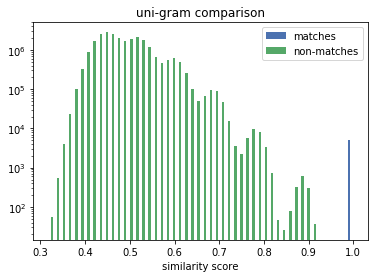

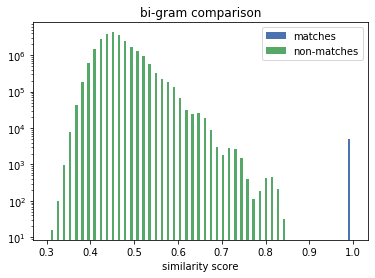

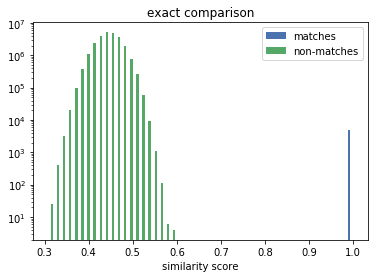

In [7]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-deep')

plt.hist([sims_matches_unigram, sims_non_matches_unigram], bins=50, label=['matches', 'non-matches'])
plt.legend(loc='upper right')
plt.yscale('log', nonposy='clip')
plt.xlabel('similarity score')
plt.title('uni-gram comparison')
plt.show()
plt.hist([sims_matches_bigram, sims_non_matches_bigram], bins=50, label=['matches', 'non-matches'])
plt.legend(loc='upper right')
plt.yscale('log', nonposy='clip')
plt.xlabel('similarity score')
plt.title('bi-gram comparison')
plt.show()
plt.hist([sims_matches_exact, sims_non_matches_exact], bins=50, label=['matches', 'non-matches'])
plt.legend(loc='upper right')
plt.yscale('log', nonposy='clip')
plt.xlabel('similarity score')
plt.title('exact comparison')
plt.show()

The true matches all lie on the vertical line above the 1.0. We can see that the *Exact Comparison* technique significantly widens the gap between matches and non-matches. 
Thus increases the range of available solving thresholds (only similarity scores above are considered a potential match) which provide the correct linkage result. 

## Numeric Comparison
This technique enables numerical comparisons of integers and floating point numbers.

Comparing numbers creates an interesting challenge. The comparison of 1000 with 1001 should lead to the same result as the comparison of 1000 and 999. They are both exactly 1 apart. However, string-based techniques like n-gram comparison will produce very different results, as the first pair has three digits in common, compared to none in the last pair. 

We have implemented a technique, where the numerical distance between two numbers relates to the similarity of the produced tokens.

We generate a dataset with one column of random 7-digit integers, and a second dataset where we alter the integers of the first dataset by +/- 100. 

In [8]:
data_A = [[i, random.randrange(10000000)] for i in range(5000)]
data_B = [[i, x + random.randint(-100,100)] for i,x in data_A]

In [9]:
a_csv = io.StringIO()
b_csv = io.StringIO()
csv.writer(a_csv).writerows(data_A)
csv.writer(b_csv).writerows(data_B)

We define two linkage schemas, one for postitional uni-gram comparison and one for numeric comparison.

The parameter *resolution* controls how many different token are generated. Clkhash will produce *2 * resolution + 1* tokens (*resolution* tokens on either side of the input value plus the input value iteself).\
And *threshold_distance* controls the sensitivity of the comparison. Only numbers that are not more than *threshold_distance* apart will produce overlapping tokens.

In [10]:
unigram_fields = [
    Ignore('rec_id'),
    IntegerSpec('random', 
                FieldHashingProperties(comparator=NgramComparison(1, True), 
                                       strategy=BitsPerFeatureStrategy(301))),
]
unigram_schema = Schema(unigram_fields, 512)

numeric_fields = [
    Ignore('rec_id'),
    IntegerSpec('random', 
                FieldHashingProperties(comparator=NumericComparison(threshold_distance=500, resolution=150),
                                       strategy=BitsPerFeatureStrategy(301))),
]
numeric_schema = Schema(numeric_fields, 512)

secret_key = 'password1234'

In [11]:
a_csv.seek(0)
hashed_data_a = generate_clk_from_csv(a_csv, secret_key, unigram_schema, header=False)
clks_a_unigram = deserialize_filters(hashed_data_a)
b_csv.seek(0)
hashed_data_b = generate_clk_from_csv(b_csv, secret_key, unigram_schema, header=False)
clks_b_unigram = deserialize_filters(hashed_data_b)
a_csv.seek(0)
hashed_data_a = generate_clk_from_csv(a_csv, secret_key, numeric_schema, header=False)
clks_a_numeric = deserialize_filters(hashed_data_a)
b_csv.seek(0)
hashed_data_b = generate_clk_from_csv(b_csv, secret_key, numeric_schema, header=False)
clks_b_numeric = deserialize_filters(hashed_data_b)

generating CLKs: 100%|██████████| 5.00k/5.00k [00:00<00:00, 11.3kclk/s, mean=229, std=5.84]
generating CLKs: 100%|██████████| 5.00k/5.00k [00:00<00:00, 12.5kclk/s, mean=229, std=5.96]
generating CLKs: 100%|██████████| 5.00k/5.00k [00:02<00:00, 1.50kclk/s, mean=228, std=5.77]
generating CLKs: 100%|██████████| 5.00k/5.00k [00:02<00:00, 1.52kclk/s, mean=228, std=5.85]


First, we will look at the similarity score distributions. We will group the similiarity scores into *matches* - the similarity scores for the correct linkage - and *non-matches*.

In [12]:
sims_matches_unigram, sims_non_matches_unigram = grouped_sim_scores_from_clks(clks_a_unigram, clks_b_unigram, 0.0)
sims_matches_numeric, sims_non_matches_numeric = grouped_sim_scores_from_clks(clks_a_numeric, clks_b_numeric, 0.0)

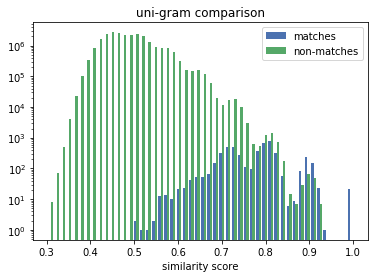

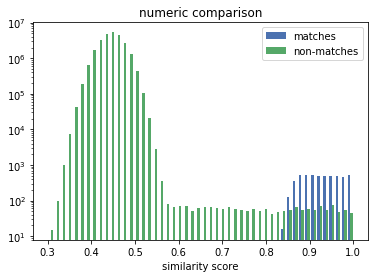

In [13]:
plt.style.use('seaborn-deep')

plt.hist([sims_matches_unigram, sims_non_matches_unigram], bins=50, label=['matches', 'non-matches'])
plt.legend(loc='upper right')
plt.yscale('log', nonposy='clip')
plt.xlabel('similarity score')
plt.title('uni-gram comparison')
plt.show()

plt.hist([sims_matches_numeric, sims_non_matches_numeric], bins=50, label=['matches', 'non-matches'])
plt.legend(loc='upper right')
plt.yscale('log', nonposy='clip')
plt.xlabel('similarity score')
plt.title('numeric comparison')
plt.show()

The distribution for the numeric comparison is very different to the uni-gram one. The similarity scores of the matches (the correct linkage) in the uni-gram case are mixed-in with the scores of the non-matches, making it challenging for a solver to decide if a similarity score denotes a match or a non-match.

The numeric comparison produces similarity scores for matches that mirrors the distribution of the numeric distances. More importanty, there is a good separation between the scores for the matches and the ones for the non-matches. The former are all above 0.8, whereas the latter are almost all (note the log scale) below 0.6.

In the next step, we will see how well the solver can find a linkage solution for the different CLKs.

In [14]:
def mapping_from_clks(clks_a, clks_b, threshold):
    """computes a mapping between clks_a and clks_b using the anonlink library"""
    results_candidate_pairs = anonlink.candidate_generation.find_candidate_pairs(
            [clks_a, clks_b],
            anonlink.similarities.dice_coefficient,
            threshold
    )
    solution = anonlink.solving.greedy_solve(results_candidate_pairs)
    return set( (a,b) for ((_, a),(_, b)) in solution)

true_matches = set((i,i) for i in range(5000))
  
def describe_matching_quality(found_matches):
    """computes and prints precision and recall of the found_matches"""
    tp = len(true_matches & found_matches)
    fp = len(found_matches - true_matches)
    fn = len(true_matches - found_matches)

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    print('Precision: {:.3f}, Recall: {:.3f}'.format(precision, recall))

In [15]:
print('results for numeric comparisons')
print('threshold 0.6:')
describe_matching_quality(mapping_from_clks(clks_a_numeric, clks_b_numeric, 0.6))
print('threshold 0.7:')
describe_matching_quality(mapping_from_clks(clks_a_numeric, clks_b_numeric, 0.7))
print('threshold 0.8:')
describe_matching_quality(mapping_from_clks(clks_a_numeric, clks_b_numeric, 0.8))

results for numeric comparisons
threshold 0.6:
Precision: 0.943, Recall: 0.941
threshold 0.7:
Precision: 0.945, Recall: 0.941
threshold 0.8:
Precision: 0.948, Recall: 0.941


In [16]:
print('results for unigram comparisons')
print('threshold 0.6:')
describe_matching_quality(mapping_from_clks(clks_a_unigram, clks_b_unigram, 0.6))
print('threshold 0.7:')
describe_matching_quality(mapping_from_clks(clks_a_unigram, clks_b_unigram, 0.7))
print('threshold 0.8:')
describe_matching_quality(mapping_from_clks(clks_a_unigram, clks_b_unigram, 0.8))

results for unigram comparisons
threshold 0.6:
Precision: 0.386, Recall: 0.383
threshold 0.7:
Precision: 0.411, Recall: 0.381
threshold 0.8:
Precision: 0.509, Recall: 0.275


As expected, we can see that the solver does a lot better when given the CLKs generated with the numeric comparison technique.

The other thing that stands out is that the results in with the numeric comparison are stable over a wider range of thresholds, in contrast to the unigram comparison, where different thresholds produce different results, thus making it more challenging to find a good threshold.


### Conclusions

The overall quality of the linkage result is heavily influence by the right choice of comparison technique for each individual feature.
In summary:
- *n-gram comparison* is best suited for fuzzy string matching. It can account for localised errors like spelling mistakes. 
- *exact comparison* produces high similiarity only for exact matches, low otherwise. This can be useful if the data is noise-free and partial similarities are not relevant. For instance credit card numbers, even if they only differ in one digit they discribe different accounts and are thus just as different then numbers which don't have any digits in common.
- *numeric comparison* provides a measure of similiarity that relates to the numerical distance of two numbers. Example use-cases are measurements like height or weight, continuous variables like salary.